In [1]:
import numpy as np 
import pandas as pd 
import os


In [2]:
from sklearn.utils import class_weight

In [4]:
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.5 MB/s eta 0:00:00
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373761 sha256=677990fa71dea880c7312379e45

In [5]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.3, r_1=0.3, r_2=1/0.3, v_l=0, v_h=3, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [6]:
eraser=get_random_eraser(p=0.6, v_l=0.2, v_h=3, s_l=0.02, s_h=0.06, r_1=0.3, r_2=1/0.7, pixel_level=True)

In [7]:
def custom_function(input_image):
    return eraser(input_image)


In [8]:
import tqdm
import random
import pathlib
import itertools
import collections

# import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

In [9]:
import glob
import logging
# import os
import re
from math import floor
from typing import Iterable, Optional

import cv2 as cv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
                                                 
from tensorflow.keras.utils import (Sequence, img_to_array)

log = logging.getLogger()


class VideoFrameGenerator(Sequence):  # pylint: disable=too-many-instance-attributes
    """
    Create a generator that return batches of frames from video
    - rescale: float fraction to rescale pixel data (commonly 1/255.)
    - nb_frames: int, number of frames to return for each sequence
    - classes: list of str, classes to infer
    - batch_size: int, batch size for each loop
    - use_frame_cache: bool, use frame cache (may take a lot of memory for \
        large dataset)
    - shape: tuple, target size of the frames
    - shuffle: bool, randomize files
    - transformation: ImageDataGenerator with transformations
    - split: float, factor to split files and validation
    - nb_channel: int, 1 or 3, to get grayscaled or RGB images
    - glob_pattern: string, directory path with '{classname}' inside that \
        will be replaced by one of the class list
    - use_header: bool, default to True to use video header to read the \
        frame count if possible
    - seed: int, default to None, keep the seed value for split
    You may use the "classes" property to retrieve the class list afterward.
    The generator has that properties initialized:
    - classes_count: number of classes that the generator manages
    - files_count: number of video that the generator can provides
    - classes: the given class list
    - files: the full file list that the generator will use, this \
        is usefull if you want to remove some files that should not be \
        used by the generator.
    """

    def __init__(  # pylint: disable=too-many-statements,too-many-locals,too-many-branches,too-many-arguments
        self,
        rescale: float = 1 / 255.0,
        nb_frames: int = 5,
        classes: list = None,
        batch_size: int = 16,
        use_frame_cache: bool = False,
        target_shape: tuple = (224, 224),
        shuffle: bool = True,
        transformation: Optional[ImageDataGenerator] = None,
        split_test: float = None,
        split_val: float = None,
        nb_channel: int = 3,
        glob_pattern: str = "./videos/{classname}/*.avi",
        use_headers: bool = True,
        seed=None,
        **kwargs,
    ):

        self.glob_pattern = glob_pattern

        # should be only RGB or Grayscale
        assert nb_channel in (1, 3)

        if classes is None:
            classes = self._discover_classes()

        # we should have classes
        if len(classes) == 0:
            log.warn(
                "You didn't provide classes list or "
                "we were not able to discover them from "
                "your pattern.\n"
                "Please check if the path is OK, and if the glob "
                "pattern is correct.\n"
                "See https://docs.python.org/3/library/glob.html"
            )

        # shape size should be 2
        assert len(target_shape) == 2

        # split factor should be a propoer value
        if split_val is not None:
            assert 0.0 < split_val < 1.0

        if split_test is not None:
            assert 0.0 < split_test < 1.0

        self.use_video_header = use_headers

        # then we don't need None anymore
        split_val = split_val if split_val is not None else 0.0
        split_test = split_test if split_test is not None else 0.0

        # be sure that classes are well ordered
        classes.sort()

        self.rescale = rescale
        self.classes = classes
        self.batch_size = batch_size
        self.nbframe = nb_frames
        self.shuffle = shuffle
        self.target_shape = target_shape
        self.nb_channel = nb_channel
        self.transformation = transformation
        self.use_frame_cache = use_frame_cache

        self._random_trans = []
        self.__frame_cache = {}
        self.files = []
        self.validation = []
        self.test = []

        _validation_data = kwargs.get("_validation_data", None)
        _test_data = kwargs.get("_test_data", None)
        np.random.seed(seed)

        if _validation_data is not None:
            # we only need to set files here
            self.files = _validation_data

        elif _test_data is not None:
            # we only need to set files here
            self.files = _test_data
        else:
            self.__split_from_vals(
                split_val, split_test, classes, shuffle, glob_pattern
            )

        # build indexes
        self.files_count = len(self.files)
        self.indexes = np.arange(self.files_count)
        self.classes_count = len(classes)

        # to initialize transformations and shuffle indices
        if "no_epoch_at_init" not in kwargs:
            self.on_epoch_end()

        kind = "train"
        if _validation_data is not None:
            kind = "validation"
        elif _test_data is not None:
            kind = "test"

        self._current = 0
        self._framecounters = {}
        print(
            "Total data: %d classes for %d files for %s"
            % (self.classes_count, self.files_count, kind)
        )

    def count_frames(self, cap, name, force_no_headers=False):
        """Count number of frame for video
        if it's not possible with headers"""
        if not force_no_headers and name in self._framecounters:
            return self._framecounters[name]

        total = cap.get(cv.CAP_PROP_FRAME_COUNT)

        if force_no_headers or total < 0:
            # headers not ok
            total = 0
            # TODO: we're unable to use CAP_PROP_POS_FRAME here
            # so we open a new capture to not change the
            # pointer position of "cap"
            capture = cv.VideoCapture(name)
            while True:
                grabbed, _ = capture.read()
                if not grabbed:
                    # rewind and stop
                    break
                total += 1

        # keep the result
        self._framecounters[name] = total

        return total

    def __split_from_vals(self, split_val, split_test, classes, shuffle, glob_pattern):
        """ Split validation and test set """

        if split_val == 0 or split_test == 0:
            # no splitting, do the simplest thing
            for cls in classes:
                self.files += glob.glob(glob_pattern.format(classname=cls))
            return

        # else, there is some split to do
        for cls in classes:
            files = glob.glob(glob_pattern.format(classname=cls))
            nbval = 0
            nbtest = 0
            info = []

            # generate validation and test indexes
            indexes = np.arange(len(files))

            if shuffle:
                np.random.shuffle(indexes)

            nbtrain = 0
            if 0.0 < split_val < 1.0:
                nbval = int(split_val * len(files))
                nbtrain = len(files) - nbval

                # get some sample for validation_data
                val = np.random.permutation(indexes)[:nbval]

                # remove validation from train
                indexes = np.array([i for i in indexes if i not in val])
                self.validation += [files[i] for i in val]
                info.append("validation count: %d" % nbval)

            if 0.0 < split_test < 1.0:
                nbtest = int(split_test * nbtrain)
                nbtrain = len(files) - nbval - nbtest

                # get some sample for test_data
                val_test = np.random.permutation(indexes)[:nbtest]

                # remove test from train
                indexes = np.array([i for i in indexes if i not in val_test])
                self.test += [files[i] for i in val_test]
                info.append("test count: %d" % nbtest)

            # and now, make the file list
            self.files += [files[i] for i in indexes]
            print("class %s, %s, train count: %d" % (cls, ", ".join(info), nbtrain))

    def _discover_classes(self):
        pattern = os.path.realpath(self.glob_pattern)
        pattern = re.escape(pattern)
        pattern = pattern.replace("\\{classname\\}", "(.*?)")
        pattern = pattern.replace("\\*", ".*")

        files = glob.glob(self.glob_pattern.replace("{classname}", "*"))
        classes = set()
        for filename in files:
            filename = os.path.realpath(filename)
            classname = re.findall(pattern, filename)[0]
            classes.add(classname)

        return list(classes)

    def next(self):
        """ Return next element"""
        elem = self[self._current]
        self._current += 1
        if self._current == len(self):
            self._current = 0
            self.on_epoch_end()

        return elem

    def get_validation_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _validation_data=self.validation,
        )

    def get_test_generator(self):
        """ Return the validation generator if you've provided split factor """
        return self.__class__(
            nb_frames=self.nbframe,
            nb_channel=self.nb_channel,
            target_shape=self.target_shape,
            classes=self.classes,
            batch_size=self.batch_size,
            shuffle=self.shuffle,
            rescale=self.rescale,
            glob_pattern=self.glob_pattern,
            use_headers=self.use_video_header,
            _test_data=self.test,
        )

    def on_epoch_end(self):
        """ Called by Keras after each epoch """

        if self.transformation is not None:
            self._random_trans = []
            for _ in range(self.files_count):
                self._random_trans.append(
                    self.transformation.get_random_transform(self.target_shape)
                )

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return int(np.floor(self.files_count / self.batch_size))

    def __getitem__(self, index):
        classes = self.classes
        shape = self.target_shape
        nbframe = self.nbframe

        labels = []
        images = []

        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        transformation = None

        for i in indexes:

            video = self.files[i]
            classname = self._get_classname(video)

            # create a label array and set 1 to the right column
            label = np.zeros(len(classes))
            col = classes.index(classname)
            label[col] = 1.0

            if video not in self.__frame_cache:
                frames = self._get_frames(
                    video, nbframe, shape, force_no_headers=not self.use_video_header
                )
                if frames is None:
                    # avoid failure, nevermind that video...
                    continue

                # add to cache
                if self.use_frame_cache:
                    self.__frame_cache[video] = frames

            else:
                frames = self.__frame_cache[video]

            # apply transformation
            # if provided
            if self.transformation is not None:
                transformation = self._random_trans[i]
                frames = [
                    custom_function(self.transformation.apply_transform(frame, transformation))
#                     self.transformation.apply_transform(frame, transformation)
                    if transformation is not None
                    else frame
                    for frame in frames
                ]

            # add the sequence in batch
            images.append(frames)
            labels.append(label)

        return np.array(images), np.array(labels)

    def _get_classname(self, video: str) -> str:
        """ Find classname from video filename following the pattern """

        # work with real path
        video = os.path.realpath(video)
        pattern = os.path.realpath(self.glob_pattern)

        # remove special regexp chars
        pattern = re.escape(pattern)

        # get back "*" to make it ".*" in regexp
        pattern = pattern.replace("\\*", ".*")

        # use {classname} as a capture
        pattern = pattern.replace("\\{classname\\}", "(.*?)")

        # and find all occurence
        classname = re.findall(pattern, video)[0]
        return classname

    def _get_frames(
        self, video, nbframe, shape, force_no_headers=False
    ) -> Optional[Iterable]:
        cap = cv.VideoCapture(video)
        total_frames = self.count_frames(cap, video, force_no_headers)
        orig_total = total_frames

        if total_frames % 2 != 0:
            total_frames += 1

        frame_step = floor(total_frames / (nbframe - 1))
        # TODO: fix that, a tiny video can have a frame_step that is
        # under 1
        frame_step = max(1, frame_step)
        frames = []
        frame_i = 0

        while True:
            grabbed, frame = cap.read()
            if not grabbed:
                break

            self.__add_and_convert_frame(
                frame, frame_i, frames, orig_total, shape, frame_step
            )

            if len(frames) == nbframe:
                break

        cap.release()

        if not force_no_headers and len(frames) != nbframe:
            # There is a problem here
            # That means that frame count in header is wrong or broken,
            # so we need to force the full read of video to get the right
            # frame counter
            return self._get_frames(video, nbframe, shape, force_no_headers=True)

        if force_no_headers and len(frames) != nbframe:
            # and if we really couldn't find the real frame counter
            # so we return None. Sorry, nothing can be done...
            log.error(
                f"Frame count is not OK for video {video}, "
                f"{total_frames} total, {len(frames)} extracted"
            )
            return None

        return np.array(frames)

    def __add_and_convert_frame(  # pylint: disable=too-many-arguments
        self, frame, frame_i, frames, orig_total, shape, frame_step
    ):
        frame_i += 1
        if frame_i in (1, orig_total) or frame_i % frame_step == 0:
            # resize
            frame = cv.resize(frame, shape)

            # use RGB or Grayscale ?
            frame = (
                cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                if self.nb_channel == 3
                else cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
            )

            # to np
            frame = img_to_array(frame) * self.rescale

            # keep frame
            frames.append(frame)


In [10]:
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None
)

In [11]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=False, featurewise_center=False, featurewise_std_normalization=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    preprocessing_function=None,
    zoom_range=(0.9,1.1),
    channel_shift_range=0.35,
    fill_mode='nearest')

In [12]:
train_gen = VideoFrameGenerator(batch_size=8, nb_frames=10, glob_pattern='/kaggle/input/reduced-classes/3mdad video3 - Copy/Train 10/{classname}/*',transformation=datagen)

Total data: 8 classes for 4033 files for train


In [13]:

"""
Utils module to provide some nice functions to develop with Keras and
Video sequences.
"""

import random as rnd
import secrets

import matplotlib.pyplot as plt
import numpy as np


def show_sample(g, index=0, random=False, row_width=22, row_height=5):
    """ Displays a batch using matplotlib.
    params:
    - g: keras video generator
    - index: integer index of batch to see (overriden if random is True)
    - random: boolean, if True, take a random batch from the generator
    - row_width: integer to give the figure height
    - row_height: integer that represents one line of image, it is multiplied by \
    the number of sample in batch.
    """
    total = len(g)
    if random:
        sample = secrets.randbelow(total)
    else:
        sample = index

    assert index < len(g)
    sample = g[sample]
    sequences = sample[0]
    labels = sample[1]

    rows = len(sequences)
    index = 1
    plt.figure(figsize=(row_width, row_height * rows))
    for batchid, sequence in enumerate(sequences):
        classid = np.argmax(labels[batchid])
        classname = g.classes[classid]
        cols = len(sequence)
        for image in sequence:
            plt.subplot(rows, cols, index)
            plt.title(classname)
            plt.imshow(image)
            plt.axis("off")
            index += 1
    plt.show()



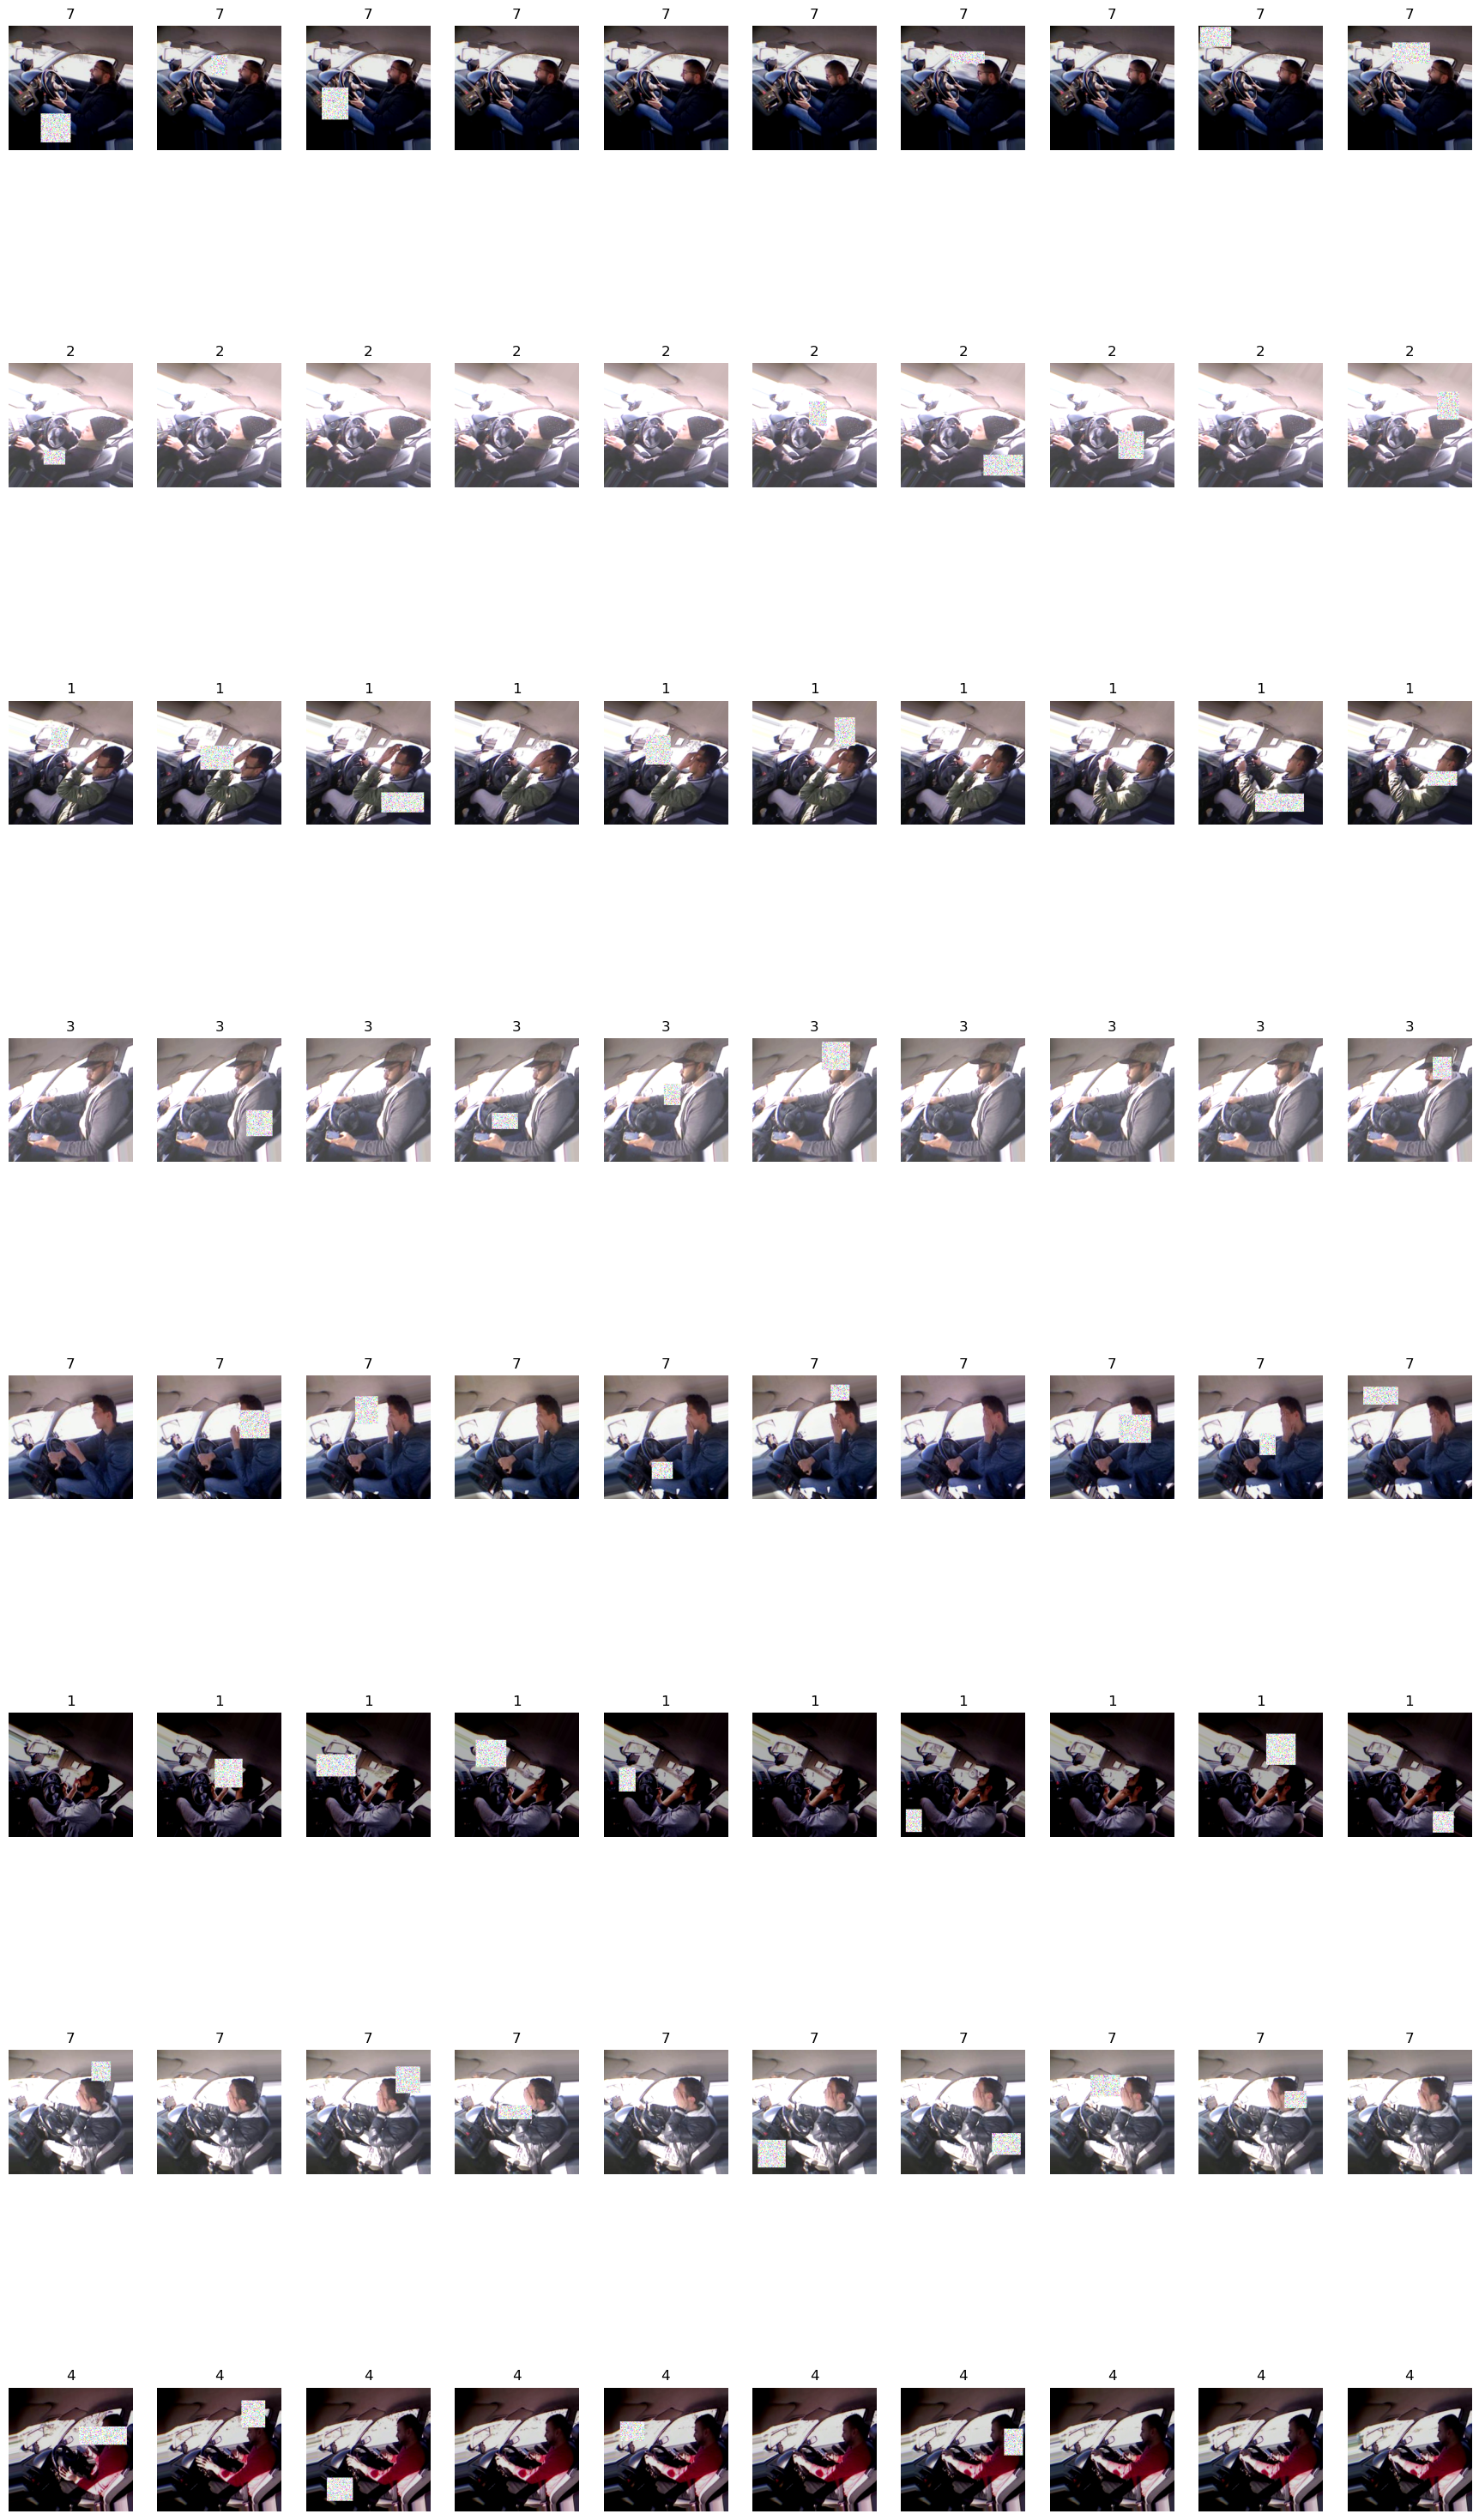

In [14]:
show_sample(train_gen, random=True)

In [15]:
test_gen = VideoFrameGenerator(batch_size=8, nb_frames=10, glob_pattern='/kaggle/input/reduced-classes/3mdad video3 - Copy/Validation 10/{classname}/*')

Total data: 8 classes for 596 files for train


In [16]:
path='/kaggle/input/reduced-classes/3mdad video3 - Copy/Train 10'
clas={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
for i in os.listdir(path):
    for j in os.listdir(os.path.join(path,i)):
        clas[int(i)]+=1

In [18]:
sum_=0
for i in clas:
    sum_+=clas[i]
print(sum_)

4033


In [19]:
class_wghts={}
for i in clas:
    class_wghts[i]=sum_/(16*clas[i])

In [20]:
print(class_wghts)

{0: 0.5092171717171717, 1: 0.5165215163934426, 2: 0.5051352705410822, 3: 0.5218685300207039, 4: 0.5273274058577406, 5: 0.45663496376811596, 6: 0.4642034990791897, 7: 0.5092171717171717}


In [21]:
!pip install tensorflow_addons

In [22]:
import tensorflow_addons as tfa

In [23]:
model_id = 'a2'
resolution = 224
batch_size=8
num_frames=10
tf.keras.backend.clear_session()
use_positional_encoding = model_id in {'a3','a4','a5'}

backbone = movinet.Movinet(model_id=model_id, conv_type ='2plus1d', se_type='2plus3d', activation='hard_swish', gating_activation='hard_sigmoid', use_positional_encoding=use_positional_encoding )
backbone.trainable = True

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])
# model.load_weights()

    # Load pre-trained weights
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a2_stream.tar.gz -O movinet_a2_stream.tar.gz -q
# !tar -xvf movinet_a2_stream.tar.gz

#     checkpoint_dir = f'movinet_{model_id}_stream'
#     checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
#     checkpoint = tf.train.Checkpoint(model=model)
#     status = checkpoint.restore(checkpoint_path)
#     status.assert_existing_objects_matched()
checkpoint_filepath = "/kaggle/working/tmp/checkpoint/cp.ckpt1"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        
    )
chk_callback=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, verbose=1, start_from_epoch=10)
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
    model = movinet_model.MovinetClassifier(
    backbone=backbone,
    num_classes=num_classes)
    model.build([batch_size, num_frames, resolution, resolution, 3])

    return model

model = build_classifier(batch_size, num_frames, resolution, backbone, 8)
    
num_epochs = 35

loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

optimizer = tfa.optimizers.AdaBelief(learning_rate = 0.0007, weight_decay= 0.0001)
print(model.summary())
model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])
checkpoint = tf.train.Checkpoint(model)
checkpoint.restore('/kaggle/input/testaccnew-76/cp.ckpt1 (1)')
results = model.fit(train_gen,
                        validation_data=test_gen,
                            epochs=num_epochs,
                            validation_freq=1,
                            verbose=1,
                    class_weight=class_wghts,
                        callbacks=[checkpoint_callback, chk_callback]
                    
                       )

Model: "movinet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, None, None, None  0         
                             , 3)]                               
                                                                 
 movinet (Movinet)           ({'stem': (None, None, N  4823882   
                             one, None, 16),                     
                              'block0_layer0': (None,            
                              None, None, None, 16),             
                              'block0_layer1': (None,            
                              None, None, None, 16),             
                              'block0_layer2': (None,            
                              None, None, None, 16),             
                              'block1_layer0': (None,            
                              None, None, None

In [24]:
real_test_gen = VideoFrameGenerator(batch_size=8, nb_frames=10, glob_pattern='/kaggle/input/reduced-classes/3mdad video3 - Copy/Test 10/{classname}/*')

Total data: 8 classes for 601 files for train


In [25]:
model.evaluate(real_test_gen, return_dict=True)

75/75 [==============================] - 17s 229ms/step - loss: 1.1713 - accuracy: 0.8000


{'loss': 1.1713111400604248, 'accuracy': 0.800000011920929}